# Inverted Pendulum Network
This is the simulation source code for the NecSys 2018 paper entitled _Distributed Control of Heterogeneous Underactuated Mechanical Systems_ by L. Valk and T. Keviczky.

Please see [this page](https://github.com/laurensvalk/underactuated-systems) for further details.




## Load Modules

In [1]:
# Numeric and symbolic libraries
import sympy as sym
import numpy as np
sym.init_printing()

# Plot libraries for main plots
from matplotlib.pyplot import subplots, rcParams

# Plot libraries for animations
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

## Symbolic derivations for single-agent modeling and IDA-PBC

#### Basic feedback linearized model

In [2]:
from systemsim.mechanical import SymbolicIDAPBCAgent
from systemsim.network import DistributedIDAPBC
from systemsim.symbolic import Equation
   
# Generalized coordinates and Latex display string
phi, x = q = sym.Matrix(sym.symbols(['\phi', 'x']))
p1, p2 = p = sym.Matrix(sym.symbols(['p_1', 'p_2']))

# Symbolic parameters and display string
symparameters = L_bob,  g,  k,  m022,    Kv = sym.symbols(
              ['L_bob','g','k','m^0_22','Kv'])

# Shorthand parameters to make computations easier
a = g/L_bob
b = 1/L_bob   

# System matrices (Acosta 2005)
F = sym.Matrix([-b*sym.cos(phi), 1])
M = sym.Matrix([[1, 0],[0, 1]]) 
V = sym.Matrix([a*sym.cos(phi)])
H = p.T*M.inv()*p/2+V
dH_dq = sym.Matrix([H]).jacobian(q).T
dV_dq = sym.Matrix([V]).jacobian(q).T       
R = sym.Matrix([[0,0],[0,0]])
n, m = F.shape

#### IDA-PBC terms

In [3]:
# Closed loop mass matrix (Acosta 2005)
m11 = k*b**2/3*sym.cos(phi)**3
m12 = -k*b/2*sym.cos(phi)**2
m22 = k*sym.cos(phi)+m022
Mcl = sym.Matrix([[m11, m12],[m12, m22]])

# Locally closed loop potential energy (Acosta 2005)
Vs = sym.Matrix([3*a/(k*b**2*sym.cos(phi)**2)])
Vcl = Vs

# Coordinated variable (Adapted from Acosta 2005)
z = x+3/b*sym.ln(1/sym.cos(phi)+sym.tan(phi))+6*m022/k/b*sym.tan(phi)

In [4]:
# Closed Loop Hamiltonian
Hcl= p.T*Mcl.inv()*p/2+Vcl

# Partial derivatives to the coordinates
dHcl_dq = sym.Matrix([Hcl]).jacobian(q).T
dpMinvp_dq = sym.Matrix([p.T*M.inv()*p]).jacobian(q).T
dpMclinvp_dq = sym.Matrix([p.T*Mcl.inv()*p]).jacobian(q).T
dVcl_dq = sym.Matrix([Vcl]).jacobian(q).T

# Input annihilator
Fp = sym.Matrix([1, b*sym.cos(phi)]).T

# J2 solution (Adapted from Acosta 2005)
gamma1, gamma2 = gammav = M.inv()*Mcl*Fp.T
alpha11, alpha12 = alpha1 = -gamma1/2*k*sym.sin(phi)*F
W = sym.Matrix([[0, -1],[1,0]]) # Opposite sign to Acosta 2005 (typo in paper?)
J2 = sym.simplify(((Mcl.inv()*p).T*alpha1)[0]*W)

#### Assert that the matching conditions hold

In [5]:
# Kinetic matching condition (Acosta 2005)
kinetic = Fp*(dpMinvp_dq-Mcl*M.inv()*dpMclinvp_dq + 2*J2*Mcl.inv()*p)
assert sym.simplify(kinetic) == sym.Matrix([0])

# Potential matching condition (Acosta 2005)
potential = Fp*(dV_dq-Mcl*M.inv()*dVcl_dq)
assert sym.simplify(potential) == sym.Matrix([0])

# Tracking potential matching condition (Valk 2018)
Psi = sym.Matrix([z]).jacobian(q).T
tracking_potential = Fp*Mcl*M.inv()*Psi
assert sym.simplify(tracking_potential) == sym.Matrix([0])

#### Make numeric model equations

In [6]:
# Kinematics map for animation given the coordinate q.
center = sym.Matrix([[x], [0]])
right = center + sym.Matrix([[0.1],[0]])
left = center - sym.Matrix([[0.1],[0]])
bob = center + sym.Matrix([[sym.cos(phi)*L_bob],[sym.sin(phi)*L_bob]])

# This draws a line representing a landing vehicle
kinematics = sym.Matrix([left.T, right.T, center.T, bob.T]).T


# Generate numeric functions for simulation
model = {
    'M': Equation(M, [q], symparameters),
    'F': Equation(F, [q], symparameters, shape_as='ndarray'),
    'dH_dq': Equation(dH_dq, [q, p], symparameters),
    'dV_dq': Equation(dV_dq, [q], symparameters),    
    'V': Equation(V, [q], symparameters),
    'R': Equation(R, [q, p], symparameters),
    'Mcl': Equation(Mcl, [q], symparameters),
    'Vcl': Equation(Vcl, [q], symparameters),
    'dHcl_dq': Equation(dHcl_dq, [q, p], symparameters),
    'dVcl_dq': Equation(dVcl_dq, [q], symparameters),    
    'J2': Equation(J2, [q, p], symparameters),
    'Kv': Equation(Kv, [], symparameters, shape_as='ndarray'),
    'Kd': Equation(sym.S(0), [], symparameters, shape_as='ndarray'),
    'Fp': Equation(Fp, [q], symparameters, shape_as='ndarray'),
    'z': Equation(z, [q], symparameters),
    'Psi': Equation(Psi, [q], symparameters, shape_as='ndarray'),
    'animation_kinematics': Equation(kinematics, [q], symparameters)
}

## Single-Agent Simulation

Demonstration of one inverted pendlum without interaction with other agents.

In [7]:
# Initial conditions
q_initial = np.array([0.5, -0.1])
p_initial = np.array([0.1, 0])
parameters = {'L_bob': 1, 'g': 9.81, 'k' : 0.05, 'm^0_22' : 0.01, 'Kv' : 0.08}

# Simulation time
time_range = np.arange(start=0,step=0.05,stop=10)

# Initialize and simulate the model
CartA = SymbolicIDAPBCAgent(model, parameters, q_initial, p_initial)
CartA.simulate(time_range)

# Plot the results
iplot(CartA.plot_state_trajectory())

The pendulum angle (blue) converges to zero. The cart position (orange) arrives at a constant nonzero position.

### Network simulation example of three pendula with two leaders (not included in paper)

We now proceed to define a network of such pendula.

Run simulation with three agents:
 A (leader) $\leftrightarrow$ B (leader) $\leftrightarrow$ C $\leftrightarrow$ (follower)

In [15]:
# Parameters for the other agents (Different bob lengths)
parametersBC = {'L_bob': 1*2, 'g': 9.81, 'k' : 0.05, 'm^0_22' : 0.01, 'Kv' : 0.08}

# Create two more inverted pendula with different initial conditions
CartB = SymbolicIDAPBCAgent(model, parametersBC, q_initial*0.5, p_initial)
CartC = SymbolicIDAPBCAgent(model, parametersBC, q_initial*-0.5, p_initial)

# All of the systems in our network
systems = [CartA, CartB, CartC]

# An undirected string of interconnections: A <---> B <----> C
weighted_edges = DistributedIDAPBC.undirected_edges({
    # For each edge, specify weight (e.g. 20) and relative distance (e.g. 0.5 or 1)
    (CartA, CartB) : (np.array([20]), np.array([0.5])),
    (CartB, CartC) : (np.array([10]), np.array([1]))
})

# For each leader in the network, specify its weight and its absolute target
leaders = {
     CartA: (np.array([20]), np.array([0.5])),
     CartB: (np.array([20]), np.array([1]))
}

# Initialize the network
network = DistributedIDAPBC(systems, weighted_edges, leaders)
time_range = np.arange(start=0,step=0.05,stop=30)

# Run simulation and show results
network.simulate(time_range)
iplot(network.plot_state_trajectory([1,5,9]))
iplot(network.plot_state_trajectory([0,4,8]))

In the first plots, the pendula converge to the desired formation (0.5, 1, and 2)

In the second plots, the pendula angles converge to zero (upright positions)

### Single agent model of a point mass

In [10]:
def car():
    # Generalized coordinates and Latex display string
    q = sym.Matrix(sym.symbols(['q']))
    p = sym.Matrix(sym.symbols(['p']))


    # Symbolic parameters and display string
    symparameters = Kv,   size,   m,   md = sym.symbols(
                  ['Kv', 'size', 'm', 'md' ])

    # System matrices
    one = sym.Matrix([[1]])
    zero = sym.Matrix([[0]])
    F = one
    V = zero
    M = one*m
    H = p.T*M*p/2+V
    dH_dq = sym.Matrix([H]).jacobian(q).T
    dV_dq = sym.Matrix([V]).jacobian(q).T   

    # IDAPBC
    Md = one*md
    Mdinv = Md.inv()
    J = zero
    Vs = zero

    # Cooperative variable
    z = sym.Matrix([q])
    Psi = z.jacobian(q).T

    # Gradients
    Hd = p.T*Mdinv*p/2+Vs
    dHd_dq = Hd.jacobian(q).T
    dVs_dq = Vs.jacobian(q).T
    dpMinvp_dq = (dH_dq-dV_dq)*2
    dVs_dq = Vs.jacobian(q).T
    dpMdinvp_dq = (dHd_dq-dVs_dq)*2

    # Kinematics map for animation given the coordinate q.
    center = sym.Matrix([q, [0]])
    right = center + sym.Matrix([[size/2],[0]])
    left = center - sym.Matrix([[size/2],[0]])

    # This draws a line representing a landing vehicle
    kinematics = sym.Matrix([left.T, center.T, right.T]).T

    # Generate numeric functions for simulation
    model = {
        'M': Equation(M, [q], symparameters, shape_as='ndarray'),
        'F': Equation(F, [q], symparameters, shape_as='ndarray'),
        'dH_dq': Equation(dH_dq, [q, p], symparameters),
        'dV_dq': Equation(dV_dq, [q], symparameters),    
        'V': Equation(V, [q], symparameters),
        'R': Equation(sym.zeros(1), [q, p], symparameters, shape_as='ndarray'),
        'Mcl': Equation(Md, [q], symparameters, shape_as='ndarray'),
        'Vcl': Equation(Vs, [q], symparameters),
        'dHcl_dq': Equation(dHd_dq, [q, p], symparameters),
        'dVcl_dq': Equation(dVs_dq, [q], symparameters),    
        'J2': Equation(J, [q, p], symparameters, shape_as='ndarray'),
        'Kv': Equation(sym.diag(Kv), [], symparameters, shape_as='ndarray'),
        'Kd': Equation(sym.diag(0), [], symparameters, shape_as='ndarray'),
        'z': Equation(z, [q], symparameters),
        'Psi': Equation(Psi, [q], symparameters, shape_as='ndarray'),
        'animation_kinematics': Equation(kinematics, [q], symparameters),
    }
    return model

# Load car model
model_car = car()

# Initial conditions
q_initial_car = np.array([-1])
p_initial_car = np.array([0])

parameters_car = {  
    'Kv': 1*15,
    'size': 0.5,
    'm': 15,
    'md': 15,
}

# Two pendula and a leader mass (simulation in paper)

In [11]:
# Initialize agents with different initial conditions than before
CartD = SymbolicIDAPBCAgent(model, parameters, np.array([0.5, 1]), p_initial)
CartE = SymbolicIDAPBCAgent(model, parametersBC, np.array([-0.25, 0]), p_initial)
massF = SymbolicIDAPBCAgent(model_car, parameters_car, q_initial_car, p_initial_car)

# All of the systems in our network
systems = [CartD, CartE, massF]

# An undirected string of interconnections: D <---> E <----> F
weighted_edges = DistributedIDAPBC.undirected_edges({
    # For each edge, specify weight (e.g. 20) and relative distance (0.5)
    (CartD, CartE) : (np.array([20]), np.array([0.5])),
    (CartE, massF) : (np.array([30]), np.array([0.5]))
})

# Make the mass a leader
leaders = { 
    massF: (np.array([50]), np.array([2]))
}

# Initialize the network
network = DistributedIDAPBC(systems, weighted_edges, leaders)
time_range = np.arange(start=0,step=0.06,stop=30.06)

# Run simulation and show results
network.simulate(time_range)
iplot(network.plot_state_trajectory([1,5,8]))
iplot(network.plot_state_trajectory([0,4]))

#### Static black-and-white figure for paper

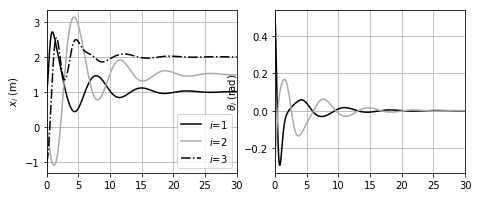

In [14]:
figure, axes = subplots(nrows=1, ncols=2, figsize=(7.5, 3))
distances, angles = axes
for axis in axes:
    axis.set_xlim([0, time_range[-1]])
    axis.grid(True)

# Linestyles
styles = ['-', '-', '-.']
color = ['#000000', '#aaaaaa', '#000000']
    
# Distance plots
distances.set_xlim([0, time_range[-1]])
for i, line,  in enumerate([1, 5, 8]):
    distances.plot(time_range, network.state_trajectory[line,:], linestyle=styles[i], color=color[i], label='$i$='+str(i+1))
distances.set_ylabel('$x_i$ (m)')
distances.legend()

# Angle plots
for i, line in enumerate([0, 4]):
    angles.plot(time_range, network.state_trajectory[line,:], linestyle=styles[i], color=color[i])
yl = angles.set_ylabel('$\\theta_i$ (rad)')
